In [129]:
from tensorflow_docs.vis import embed
import tensorflow as tf
from tensorflow import keras
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import imageio
import cv2
import os
from tqdm import tqdm
import math
import pandas as pd
import matplotlib.pyplot as plt

In [114]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 100

MAX_SEQ_LENGTH = 200
NUM_FEATURES = 2048

In [115]:
train = pd.read_csv("/Users/pabloneira/AplicacionesTendenciasAD/train.csv", usecols=['title','rating'])

In [116]:
train['rating'] = train[['rating']].astype(str)

In [138]:
sequence_model = keras.models.load_model('sequence_model.sav')

In [118]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train["rating"])
)
print(label_processor.get_vocabulary())

['1', '2', '3', '4', '5']


In [131]:
def load_video(path, max_frames=200, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [132]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

In [133]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

In [134]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask

In [135]:
def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("/Volumes/NEIRA/AplicacionesTendenciasAD/video_train", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames

In [151]:
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")

Test video path: El Planeta de los Simios (Trailer español).mp4
  3: 28.99%
  2: 23.88%
  1: 18.28%
  5: 15.42%
  4: 13.42%



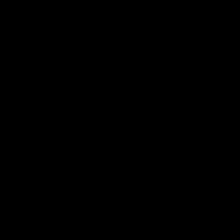

In [154]:
test_video = np.random.choice(videos)
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

In [127]:
import os
ejemplo_dir = '/Volumes/NEIRA/AplicacionesTendenciasAD/video_train'
contenido = os.listdir(ejemplo_dir)
videos = []
for fichero in contenido:
    if os.path.isfile(os.path.join(ejemplo_dir, fichero)) and fichero.endswith('.mp4'):
        videos.append(fichero)
print(videos)

['High Seas _ Official trailer _ Netflix.mp4', 'Ice age 3 Nuevo trailer en castellano.mp4', '4_The Forbidden Kingdom Trailer [HD].mp4', 'Bratz La Pelicula TRAILER.mp4', 'JOKER - Teaser Trailer - Now Playing In Theaters.mp4', 'The Batman - DC FanDome Teaser.mp4', '2067 (2020) 🎥 Tráiler En ESPAÑOL (Subtitulado) LATAM 🎬 Película Ciencia Ficción Drama.mp4', 'Dando la nota - Trailer español.mp4', 'Legends of Tomorrow Trailer  Español.mp4', 'Here Comes The Rain _ trailer(360p).mp4', 'Ben 10 The Movie Teaser Trailer (2022) Tom Holland Live Action  Concept.mp4', 'El invitado - Trailer español (HD).mp4', 'The Adventures of Rocky & Bullwinkle Official Trailer 1 - Robert De Niro Movie (2000) HD.mp4', 'TRANSFORMERS_ CYBERVERSE.mp4', 'CREPÚSCULO TRAILER.mp4', 'JACK Y SU GEMELA - Tráiler oficial en ESPAÑOL  Sony Pictures España.mp4', 'The 100 - Trailer Subtitulado Primera Temporada.mp4', 'TRAILER- Hobgoblins (1988).mp4', 'Deal of the Century (1983) Official Trailer - Chevy Chase Sigourney Weaver Mov

INTEGRACIÓN WEB